In [98]:
DATA_PATH = "data/emotions"
FILES = ['train.txt', 'val.txt', 'test.txt']

                                            sentence  emotion
0                   i am feeling profoundly peaceful      joy
1  i felt myself shrinking and feeling horrible a...  sadness
2  i feel on the verge of tears from weariness i ...     love
3  i didn t expect reps to make me ache really es...  sadness
4              i feel about watching romantic movies     love

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  2000 non-null   object
 1   emotion   2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB
None



Text(0.5, 1.0, 'Emotions distribution')

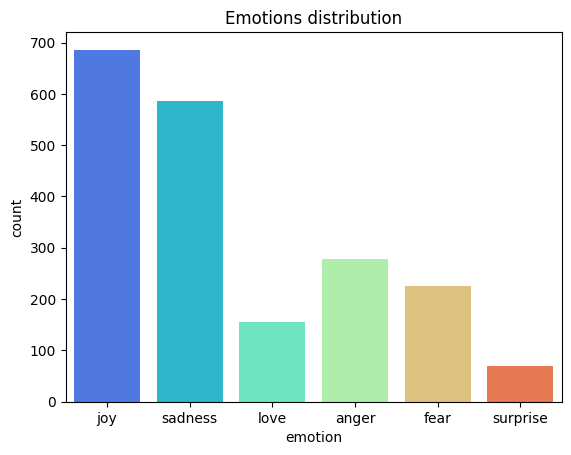

In [99]:
from pathlib import Path
from pandas import read_csv, DataFrame, concat
from seaborn import countplot

def read_data_file(file_path: Path) -> DataFrame:
    # Přečteme CSV soubor s ; jako oddělovačem
    df = read_csv(file_path, sep=';', header=None)

    # Přejmenujeme sloupce
    df.columns = ['sentence', 'emotion']

    return df

# Načteme všechny soubory a spojíme je do jednoho DataFramu
DATA_FRAMES = list(map(lambda file_name: read_data_file(Path(f"{DATA_PATH}/{file_name}")), FILES))
DF_MERGED = concat(DATA_FRAMES, ignore_index=True)

# Načteme všechny soubory a spojíme je do jednoho DataFramu
DF_MERGED = DF_MERGED.sample(frac=0.1).reset_index(drop=True)

# Vypíšeme prvních 5 řádků a informace o DataFramu
print(DF_MERGED.head(), end='\n\n')
print(DF_MERGED.info(), end='\n\n')
countplot(x='emotion', data=DF_MERGED, palette='rainbow').set_title('Emotions distribution')

                                            sentence  emotion  length
0                   i am feeling profoundly peaceful      joy       5
1  i felt myself shrinking and feeling horrible a...  sadness       9
2  i feel on the verge of tears from weariness i ...     love      23
3  i didn t expect reps to make me ache really es...  sadness      31
4              i feel about watching romantic movies     love       6

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  2000 non-null   object
 1   emotion   2000 non-null   object
 2   length    2000 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 47.0+ KB
None



Text(0.5, 1.0, 'Emotions distribution')

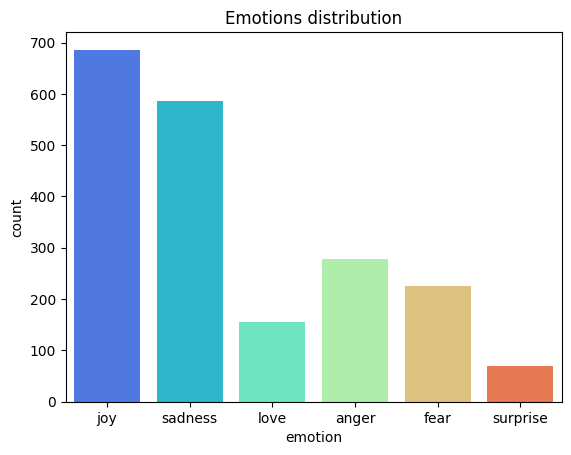

In [100]:
DF_MERGED['length'] = DF_MERGED['sentence'].apply(lambda sentence: len(sentence.split(' ')))
print(DF_MERGED.head(), end='\n\n')
print(DF_MERGED.info(), end='\n\n')
countplot(x='emotion', data=DF_MERGED, palette='rainbow').set_title('Emotions distribution')

                                            sentence  emotion  length
0                   i am feeling profoundly peaceful      joy       5
1  i felt myself shrinking and feeling horrible a...  sadness       9
2  i feel on the verge of tears from weariness lo...     love      22
3  i didn expect reps to make me ache really espe...  sadness      27
4              i feel about watching romantic movies     love       6



Text(0.5, 1.0, 'Emotions distribution')

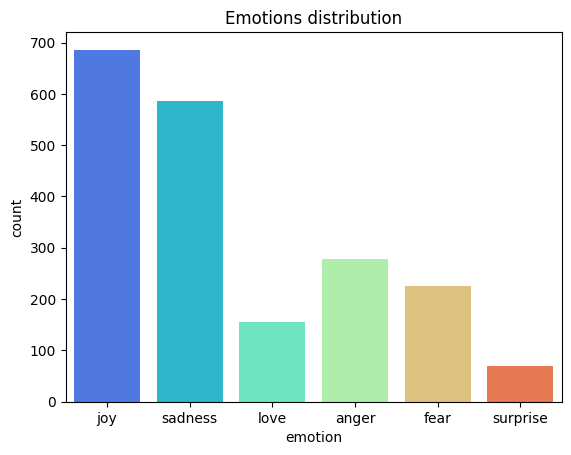

In [101]:
from regex import regex as re

def clean_sentence(sentence: str) -> str:
    # Odstraníme všechny speciální znaky

    sentence = re.sub(r'\W', ' ', sentence)

    # Odstraníme osamocená písmena
    sentence= re.sub(r'\s+[a-zA-Z]\s+', ' ', sentence)
    sentence = re.sub(r'\^[a-zA-Z]\s+', ' ', sentence) 

    # Substituujeme několik mezer jednou mezerou
    sentence = re.sub(r'\s+', ' ', sentence, flags=re.I)

    # Převedeme na lowercase
    sentence = sentence.lower()
    return sentence

DF_MERGED['sentence'] = DF_MERGED['sentence'].apply(clean_sentence)
DF_MERGED['length'] = DF_MERGED['sentence'].apply(lambda sentence: len(sentence.split(' ')))
print(DF_MERGED.head(), end='\n\n')
countplot(x='emotion', data=DF_MERGED, palette='rainbow').set_title('Emotions distribution')

In [112]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import stopwords
from pickle import dump as dump_object

vectorizer = TfidfVectorizer (stop_words=stopwords.words('english'))
tf_idf = vectorizer.fit_transform(DF_MERGED["sentence"]).toarray()

dump_object(tf_idf, open('out/tf_idf.pkl', 'wb'))

In [113]:
from sklearn.model_selection import train_test_split
from pickle import load as load_object

tf_idf = load_object(open('out/tf_idf.pkl', 'rb'))
X_train, X_test, y_train, y_test = train_test_split(tf_idf, DF_MERGED["emotion"], test_size=0.2, random_state=0)

In [114]:
# Models
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB

models = {
    'Decision Tree': DecisionTreeClassifier(),
    # 'Random Forest': RandomForestClassifier(),
    # 'SVM': SVC(),
    # 'Logistic Regression': LogisticRegression(),
    # 'KNN': KNeighborsClassifier(),
    # 'Naive Bayes': BernoulliNB()
}

accuracies = {}

# cross validation
for model_name, model_instance in models.items():
    accuracies[model_name] = cross_val_score(model_instance, X_train, y_train, scoring='accuracy', cv=StratifiedKFold(10)).mean()

acc = DataFrame({'Model': accuracies.keys(), 'Accuracy': accuracies.values()}).sort_values(by='Accuracy', ascending=False)
print(acc)

# best model based on accuracy
best_model_name = acc.iloc[0]['Model']
print(best_model_name)
best_model = models.get(best_model_name)

# fit best model
best_model.fit(X_train, y_train)

# dump model
model_name_lowercase = acc.iloc[0]['Model'].lower().replace(' ', '_')
model_fname = f'out/model_{model_name_lowercase}.pkl'
dump_object(best_model, open(model_fname, 'wb'))

           Model  Accuracy
0  Decision Tree  0.415556
Decision Tree


In [115]:
from pickle import load as load_object
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

ml = load_object(open(model_fname,'rb'))
tfidf = load_object(open('out/tf_idf.pkl','rb'))

pred = best_model.predict(X_test)

print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))
print(accuracy_score(y_test, pred))

[[18  0  9  0  4  0]
 [ 3  7  0  0  1  0]
 [31  0 31  1  5  0]
 [ 8  0  2  2  0  0]
 [26  2 16  1 24  0]
 [ 3  2  2  0  0  2]]
              precision    recall  f1-score   support

       anger       0.20      0.58      0.30        31
        fear       0.64      0.64      0.64        11
         joy       0.52      0.46      0.48        68
        love       0.50      0.17      0.25        12
     sadness       0.71      0.35      0.47        69
    surprise       1.00      0.22      0.36         9

    accuracy                           0.42       200
   macro avg       0.59      0.40      0.42       200
weighted avg       0.56      0.42      0.44       200

0.42


In [116]:
from termcolor import colored

data = {
    "The rude behavior of that person made me furious.": "anger",
    "I'm feeling anxious about the upcoming exam.": "fear",
    "Winning the championship brought me overwhelming joy.": "joy",
    "I am deeply in love with you and cherish every moment together.": "love",
    "The news of their breakup left me feeling so sad for them.": "sadness",
    "His arrogant attitude annoys me to no end.": "anger",
    "Walking alone in the dark gives me a sense of unease.": "fear",
    "Discovering a hidden talent filled me with pure joy.": "joy",
    "Your kindness and support mean the world to me.": "love",
    "The loss of a beloved pet has left me heartbroken.": "sadness"
}

accuracy = 0
for sentence, emotion in data.items():
  sentence_to_predict = clean_sentence(sentence)
  sentence_to_predict = vectorizer.transform([sentence_to_predict]).toarray()
  match = emotion == best_model.predict(sentence_to_predict)[0]
  print(colored(f"{sentence} - expected: {emotion}, actual: {best_model.predict(sentence_to_predict)[0]}", "green" if match else "red"), end='\n')
  accuracy += 1 if match else 0

print(f"Accuracy: {accuracy / len(data) * 100}%")

The rude behavior of that person made me furious. - expected: anger, actual: anger
I'm feeling anxious about the upcoming exam. - expected: fear, actual: fear
Winning the championship brought me overwhelming joy. - expected: joy, actual: anger
I am deeply in love with you and cherish every moment together. - expected: love, actual: anger
The news of their breakup left me feeling so sad for them. - expected: sadness, actual: anger
His arrogant attitude annoys me to no end. - expected: anger, actual: anger
Walking alone in the dark gives me a sense of unease. - expected: fear, actual: anger
Discovering a hidden talent filled me with pure joy. - expected: joy, actual: anger
Your kindness and support mean the world to me. - expected: love, actual: anger
The loss of a beloved pet has left me heartbroken. - expected: sadness, actual: anger
Accuracy: 30.0%
